In [2]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer



## Erste Datenanalyse

* Jede Zeile unseres Datensatzes besteht aus einem String und boolean
* Analyse mit NumPy/Pandas nicht möglich
* Daher verwenden wir ein Bild eingelesen als array

In [3]:
image = Image.open('Data/PulledPork.jpg')

# Bild in ein NumPy-Array umwandeln
image_array = np.array(image)

In [4]:
spam_dataset = pd.read_csv('Data/spam_dataset.csv')
spam_dataset.head()

,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base reg...",0
1,"Congratulations, you've won a prize! Call us n...",1
2,You have been pre-approved for a credit card w...,1
3,"Limited time offer, act now! Only a few spots ...",1
4,Your loan has been approved! Transfer funds to...,1


In [5]:
r_channel_pixel_values = image_array[:, :, 0].flatten()
g_channel_pixel_values = image_array[:, :, 1].flatten()
b_channel_pixel_values = image_array[:, :, 2].flatten()

# Satische Analyse
* Sind die Daten homogen verteilt?
    * Nein, siehe Histogramm
* Gibt es Ausreißer?
    * Bei einem Schwellenwert ab 2.5 x Standardabweichung nicht
    * Bei einem Schwellenwert <= 2 x Standardabweichung ja (23892 Ausreißer bei 2)


In [6]:
# Statistische Analyse der Pixelwerte
mean_value = np.mean(r_channel_pixel_values)
median_value = np.median(r_channel_pixel_values)
std_dev = np.std(r_channel_pixel_values)

print(f"Mittelwert der Pixelwerte: {mean_value}")
print(f"Median der Pixelwerte: {median_value}")
print(f"Standardabweichung der Pixelwerte: {std_dev}")

# Schwellenwert für Ausreißer 
# (z.B. 3 Standardabweichungen vom Mittelwert entfernt)
upper_limit = mean_value + 2 * std_dev
lower_limit = mean_value - 2 * std_dev


outliers = np.sum((r_channel_pixel_values > upper_limit) | (r_channel_pixel_values < lower_limit))
print(f"Anzahl der Ausreißer: {outliers}")


Mittelwert der Pixelwerte: 105.629503125
Median der Pixelwerte: 100.0
Standardabweichung der Pixelwerte: 69.36882514398872
Anzahl der Ausreißer: 23892


## Kannst du durch die statistischen Werte schon irgenwelche Schlüsse aus deinen Daten ziehen?
   * Durch den Mittelwert der Farbkanäle erkennt man das die Pixel durchschnittlich eher Rötlich sind

In [7]:
r_channel_mean_value = np.mean(r_channel_pixel_values)
g_channel_mean_value = np.mean(g_channel_pixel_values)
b_channel_mean_value = np.mean(b_channel_pixel_values)

print(f"Mittelwert der Pixelwerte (R-Kanal): {r_channel_mean_value}")
print(f"Mittelwert der Pixelwerte (G-Kanal): {g_channel_mean_value}")
print(f"Mittelwert der Pixelwerte (B-Kanal): {b_channel_mean_value}")

Mittelwert der Pixelwerte (R-Kanal): 105.629503125
Mittelwert der Pixelwerte (G-Kanal): 95.24125833333333
Mittelwert der Pixelwerte (B-Kanal): 89.60549166666667


## Histogram der Pixelwerte (R-Kanal)

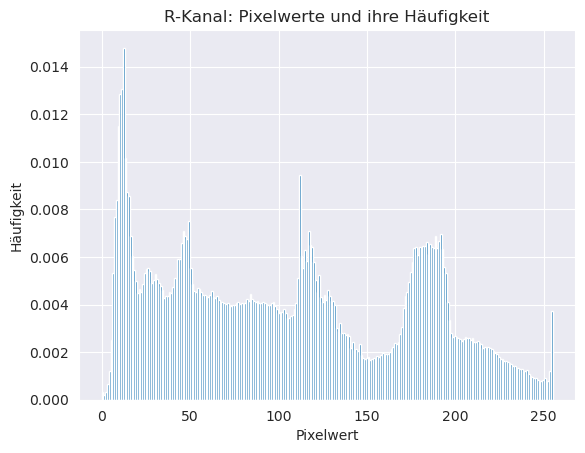

In [8]:
plt.hist(r_channel_pixel_values, bins=256, range=(0, 255), density=True)
plt.title('R-Kanal: Pixelwerte und ihre Häufigkeit')
plt.xlabel('Pixelwert')
plt.ylabel('Häufigkeit')
plt.show()

# Suche dir eine Spalte zum Sortieren deiner Daten und gib die 3 höchsten und die drei niedrigsten Werte aus
* Höchste und niedrigste Pixelwerte
* Längste und Kürzeste Emails

In [9]:
sorted_pixels = np.sort(r_channel_pixel_values)

print(f"3 niedrigste Pixelwerte: {sorted_pixels[:3]}")
print(f"3 höchste Pixelwerte: {sorted_pixels[-3:]}")


3 niedrigste Pixelwerte: [0 0 0]
3 höchste Pixelwerte: [255 255 255]


In [10]:
lengths = spam_dataset['message_content'].apply(len).tolist()

sorted_lengths = sorted(lengths)

lowest_3 = sorted_lengths[:3]
highest_3 = sorted_lengths[-3:]

print(f"3 kürzeste Emails: {lowest_3}")
print(f"3 längste Emails: {highest_3}")

3 kürzeste Emails: [162, 162, 162]
3 längste Emails: [511, 511, 514]


Erstelle ein neues NumPy Array mit nur einer Spalte aus deinem Datensatz.

In [11]:
red_channel = image_array[:, :, 0]  # Roter Kanal

# Ausgabe der ersten 5 Werte der neuen Spalte
print(red_channel[:5])

[[254 254 254 ...  30  28  26]
 [254 254 254 ...  32  30  28]
 [254 254 254 ...  34  32  31]
 [254 254 254 ...  35  33  32]
 [254 254 254 ...  42  41  38]]


## Unterschiede Numpy und Pandas
* Numpy ist für numerische Berechnungen optimiert
* Pandas ist für Datenanalyse optimiert
* Numpy ist schneller als Pandas
* Numpy ist besser für mathematische Operationen
* Pandas ist besser für Datenmanipulation
* Numpy ist besser für 1D Arrays

# Visualisierung


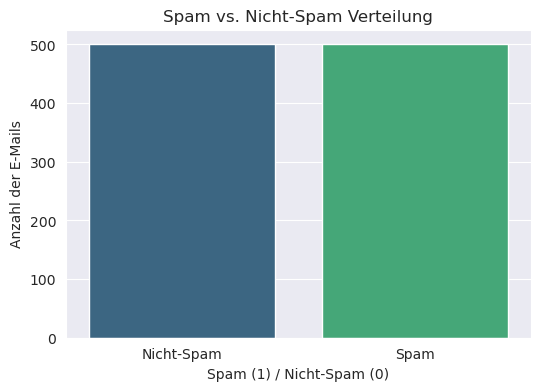

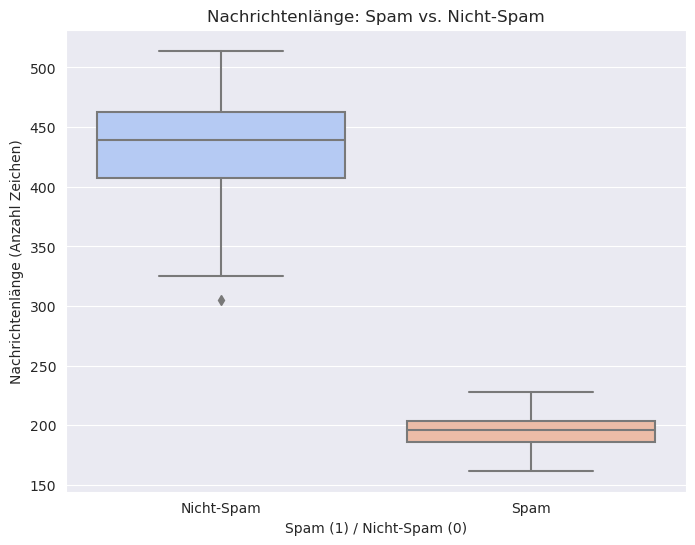

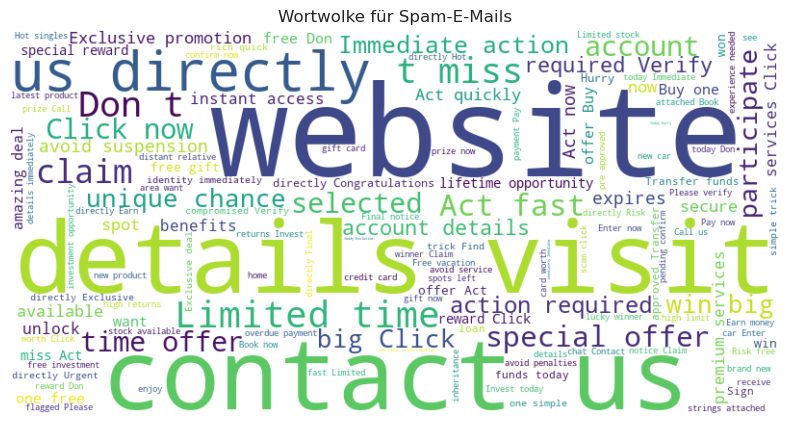

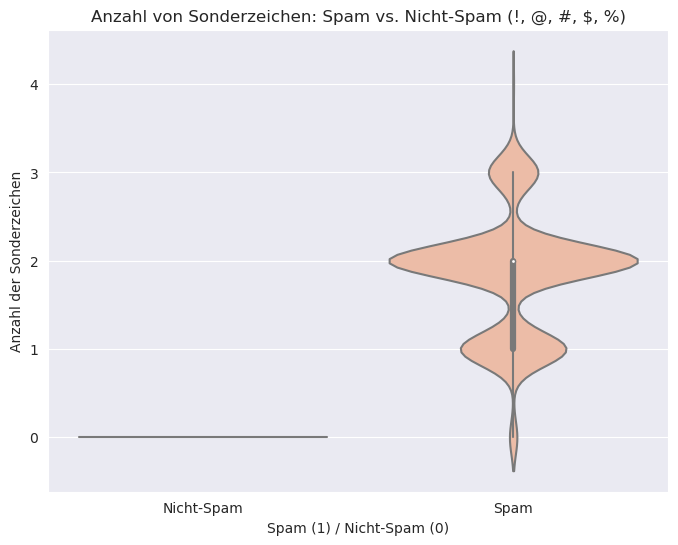

In [12]:
# Spam vs. Nicht-Spam Verteilung
spam_counts = spam_dataset['is_spam'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=spam_counts.index, y=spam_counts.values, palette='viridis')
plt.title('Spam vs. Nicht-Spam Verteilung')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Anzahl der E-Mails')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

# Durchschnittliche Länge der E-Mails in Bezug auf Spam vs. Nicht-Spam
spam_dataset['message_length'] = spam_dataset['message_content'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spam', y='message_length', data=spam_dataset, palette='coolwarm')
plt.title('Nachrichtenlänge: Spam vs. Nicht-Spam')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Nachrichtenlänge (Anzahl Zeichen)')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

# Wortwolke für Spam-E-Mails
spam_words = ' '.join(spam_dataset[spam_dataset['is_spam'] == 1]['message_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wortwolke für Spam-E-Mails')
plt.show()

# Verteilung der Sonderzeichen in Spam vs. Nicht-Spam
spam_dataset['special_char_count'] = spam_dataset['message_content'].str.count(r'[!@#$%&]')

# Erstellen eines Violinplots
plt.figure(figsize=(8, 6))
sns.violinplot(x='is_spam', y='special_char_count', data=spam_dataset, palette='coolwarm')
plt.title('Anzahl von Sonderzeichen: Spam vs. Nicht-Spam (!, @, #, $, %)')
plt.xlabel('Spam (1) / Nicht-Spam (0)')
plt.ylabel('Anzahl der Sonderzeichen')
plt.xticks([0, 1], ['Nicht-Spam', 'Spam'])
plt.show()

 # Data Preperation

In [13]:
sleep_dataset = pd.read_csv('Data/student_sleep_patterns.csv')
sleep_dataset.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


In [14]:
duplikate = sleep_dataset[sleep_dataset.duplicated()]
if not duplikate.empty:
    print(f"Es gibt {duplikate.shape[0]} Duplikate im Datensatz.")
    print("Die Duplikate sind:")
    print(duplikate)
else:
    print("Es gibt keine Duplikate im Datensatz.")

Es gibt keine Duplikate im Datensatz.


Gibt es Daten die nicht relevant sind?

NAN Values verändern:

In [15]:
gender_mapping = {'Male': 1, 'Female': 2, 'Other': 3}
university_mapping = {'1st Year': 1, '2nd Year': 2, '3rd Year': 3, '4th Year': 4}
sleep_dataset['Gender'] = sleep_dataset['Gender'].map(gender_mapping)
sleep_dataset['University_Year'] = sleep_dataset['University_Year'].map(university_mapping)
sleep_dataset.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,3,2,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,1,1,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,1,4,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,3,4,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,1,4,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


In [22]:
numeric_cols = sleep_dataset.select_dtypes(include=['float64', 'int64']).columns
z_scores = sleep_dataset[numeric_cols].apply(zscore)

outliers_zscore = (z_scores > 3) | (z_scores < -3)
outliers_indices = outliers_zscore.any(axis=1)
outliers_data = sleep_dataset[outliers_indices]
outliers_data


,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End


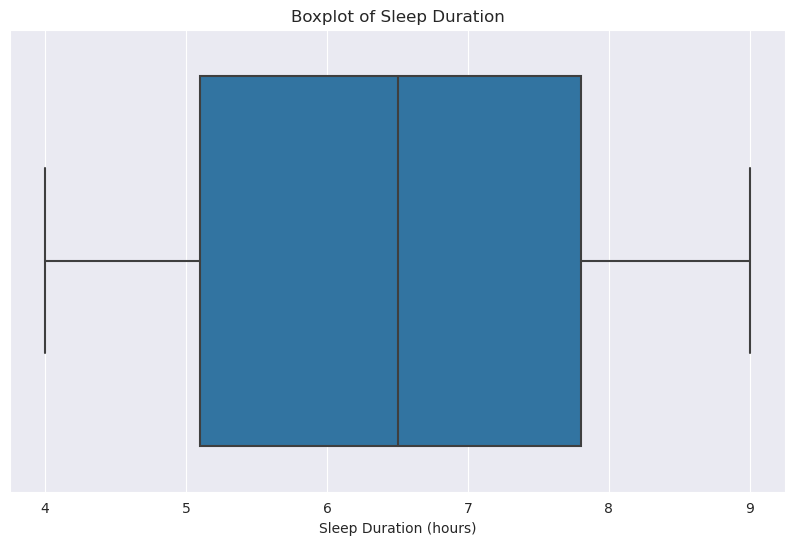

In [23]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=sleep_dataset['Sleep_Duration'])
plt.title('Boxplot of Sleep Duration')
plt.xlabel('Sleep Duration (hours)')
plt.show()

## Ausreißer:
Da es keine Ausreißer gibt, können wir die Daten so lassen wie sie sind.

# Data Validation

## Regression
* Welche Werte können mit Regression vorhergesagt werden?
    * Schlafdauer, Studienzeit, Bildschirmzeit, Koffeinaufnahme, körperliche Aktivität, Schlafqualität
* Vorbereitungsschritte
    * Kategorische Werte in numerische Werte umwandeln
    * Skalierung der numerichen Werte
* Wie gut funktioniert das Modell?
    * Nicht gut, da die Daten nicht linear sind
* Interpretation der Confusion Matrix
    * Die Werte schräg von oben links nach unten rechts sind die korrekten Vorhersagen

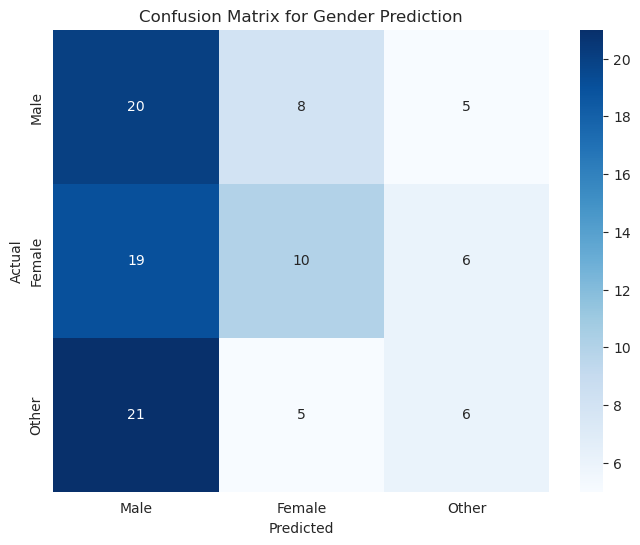

              precision    recall  f1-score   support

        Male       0.33      0.61      0.43        33
      Female       0.43      0.29      0.34        35
       Other       0.35      0.19      0.24        32

    accuracy                           0.36       100
   macro avg       0.37      0.36      0.34       100
weighted avg       0.38      0.36      0.34       100



In [17]:
# Define features and target
features = ['Study_Hours', 'Screen_Time', 'Caffeine_Intake', 'Physical_Activity', 'Sleep_Quality', 'Sleep_Duration', 'University_Year']
target = 'Gender'

# Extract features and target from the dataset
X = sleep_dataset[features]
y = sleep_dataset[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the classification model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female', 'Other'], yticklabels=['Male', 'Female', 'Other'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gender Prediction')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Male', 'Female', 'Other']))


## Decision Tree
Für Deciscion Tree verwenden wir den Spam Datensatz

* Welche Klassen
    * Span, Nicht-Spam 
* Datensatz ist Ausgeglichen
* Vorverarbeitungsschritte
    * keine  
* Wie gut funktioniert das Modell
    * Perfekt 

In [18]:
X = spam_dataset['message_content']
y = spam_dataset['is_spam']

# Convert text data to numerical data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Spam Classification')
plt.show()

NameError: name 'DecisionTreeClassifier' is not defined